In [1]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as mtn
import os
mycolor = '#3d766d'

In [2]:
folder = r"C:\Users\chira\Documents\All Files\PortFolio Dashboards💸\#2 MarketingDashboard\Data"

In [3]:
tables = {}

In [4]:
for files in os.listdir(folder):
    names = files.replace('.csv', '').replace('Dim', ''). replace("_", "").replace("Fact", "").lower().replace("marketing", "")
    tables[names] = pd.read_csv(os.path.join(folder, files))
    print(names)

campaign
customer
products
conversions
performance


In [5]:
customers = tables["customer"]
campaigns = tables["campaign"]
products = tables["products"]
conversions = tables["conversions"]
performance = tables["performance"]

# Fact Tables Analysis

### Conversions Table

In [6]:
# --- Null Values
pd.isnull(conversions).sum()

ConversionId       0
CustomerID         0
ProductID          0
CompaignID         0
ConversionType     0
Conversion_Date    0
Revenue            0
dtype: int64

In [7]:
# --- Description
conversions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ConversionId     150 non-null    object
 1   CustomerID       150 non-null    int64 
 2   ProductID        150 non-null    object
 3   CompaignID       150 non-null    int64 
 4   ConversionType   150 non-null    object
 5   Conversion_Date  150 non-null    object
 6   Revenue          150 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 8.3+ KB


In [8]:
# --- Converting Date into Date format
conversions.rename(columns = {'Conversion_Date' : 'Date'}, inplace = True)

conversions['Date'] = pd.to_datetime(conversions['Date'], format = 'mixed')

In [9]:
# --- Description
conversions.describe()

,CustomerID,CompaignID,Date,Revenue
count,150.000000,150.000000,150,150.000000
mean,79.973333,6.213333,2023-09-20 03:50:24,5007.746667
min,1.000000,1.000000,2022-01-09 00:00:00,48.000000
25%,42.000000,4.000000,2022-12-27 00:00:00,1160.750000
50%,82.500000,7.000000,2023-11-01 00:00:00,3300.500000
75%,120.000000,9.000000,2024-06-13 12:00:00,6811.750000
max,149.000000,10.000000,2025-05-17 00:00:00,21332.000000
std,44.210440,2.883852,NaN,5067.759255


### Performance Table

In [10]:
# --- Null Values
pd.isnull(performance).sum()

Date                 0
Campaign_ID          0
ProductID            0
Customer_ID          0
Status               0
Estimated Revenue    0
Ad_spend             0
dtype: int64

In [11]:
# --- Description
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               100000 non-null  object 
 1   Campaign_ID        100000 non-null  int64  
 2   ProductID          100000 non-null  object 
 3   Customer_ID        100000 non-null  int64  
 4   Status             100000 non-null  object 
 5   Estimated Revenue  100000 non-null  int64  
 6   Ad_spend           100000 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [12]:
# --- Converting Date into Date format

performance['Date'] = pd.to_datetime(performance['Date'], format = 'mixed')

# Exploratory Data Analysis

### 1.	What is the distribution of estimated revenue across all campaigns?

In [13]:
CampaignCombined = performance.merge(campaigns, on = "Campaign_ID", how = "inner")

In [14]:
Distribution = CampaignCombined.groupby("Campaign_Name")['Estimated Revenue'].sum().reset_index()

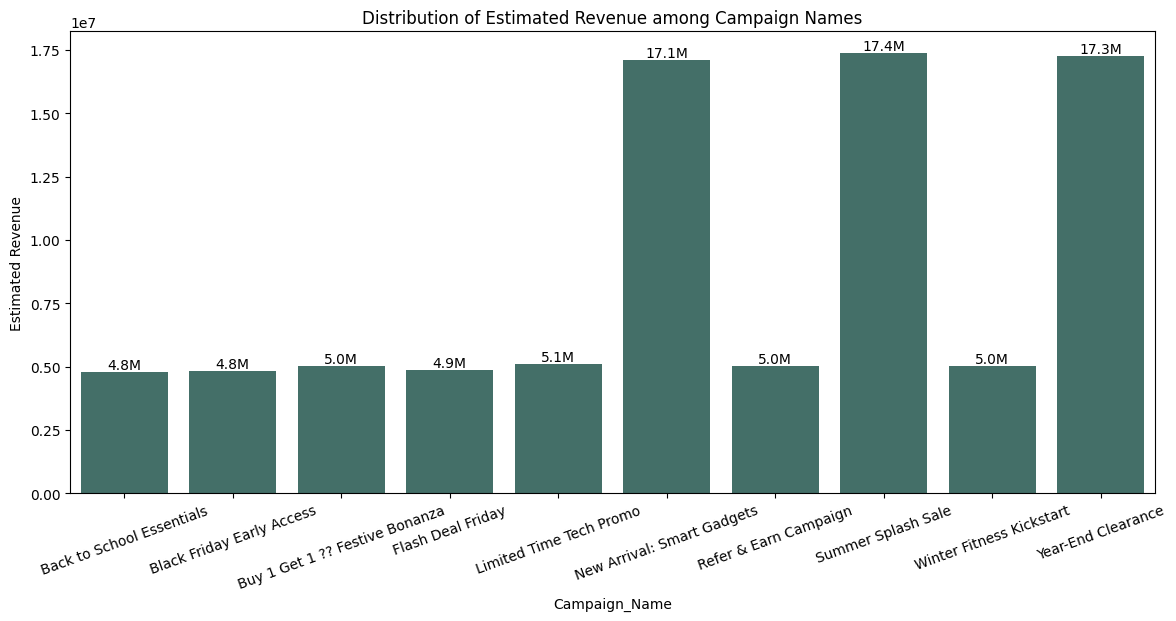

In [15]:
mtn.figure(figsize = (14,6))
ax = sea.barplot(x = "Campaign_Name", y = "Estimated Revenue", data = Distribution, color = mycolor)
ax.bar_label(ax.containers[0], labels=[f"{v.get_height()/1_000_000:.1f}M" for v in ax.containers[0]])
mtn.xticks(rotation = 20)
mtn.title('Distribution of Estimated Revenue among Campaign Names')
mtn.show()

### 2.	Which products have the highest conversion success rate?

In [16]:
# ---- Product/Conversions

ProductConversions = conversions.groupby('ProductID').size().reset_index(name = 'Conversions')

# ---- Product/Clicks

ProductClicks = performance[performance['Status'] == 'Clicks'].groupby('ProductID').size().reset_index(name = 'Clicks')

In [17]:
FinalTable = ProductConversions.merge(products, on = "ProductID", how = "inner").merge(ProductClicks, on = "ProductID", how = "inner")[["Product Name", "Clicks", "Conversions"]]

In [18]:
FinalTable["ConversionRate"] = round(FinalTable["Conversions"] * 100.0/FinalTable["Clicks"],1)

In [19]:
# ---- Top 5 Products by Conversion Rate

FinalTable.sort_values(by = "ConversionRate", ascending = False).head()

,Product Name,Clicks,Conversions,ConversionRate
9,Galaxy Soundbar,211,11,5.2
10,Titan Hard Drive,276,13,4.7
13,UltraSonic Headphones,257,10,3.9
11,Quantum Phone X,247,9,3.6
15,Nova Tablet,235,8,3.4


### 3.	Analyze the trend of ad spend over time – is it increasing, decreasing, or seasonal?

In [20]:
performance["Month_Name"] = performance["Date"].dt.month_name()
performance["Sort"] = performance["Date"].dt.month

In [21]:
TimeLine = round(performance.groupby(["Month_Name", "Sort"])["Ad_spend"].sum().reset_index().sort_values(by = "Sort"),1)

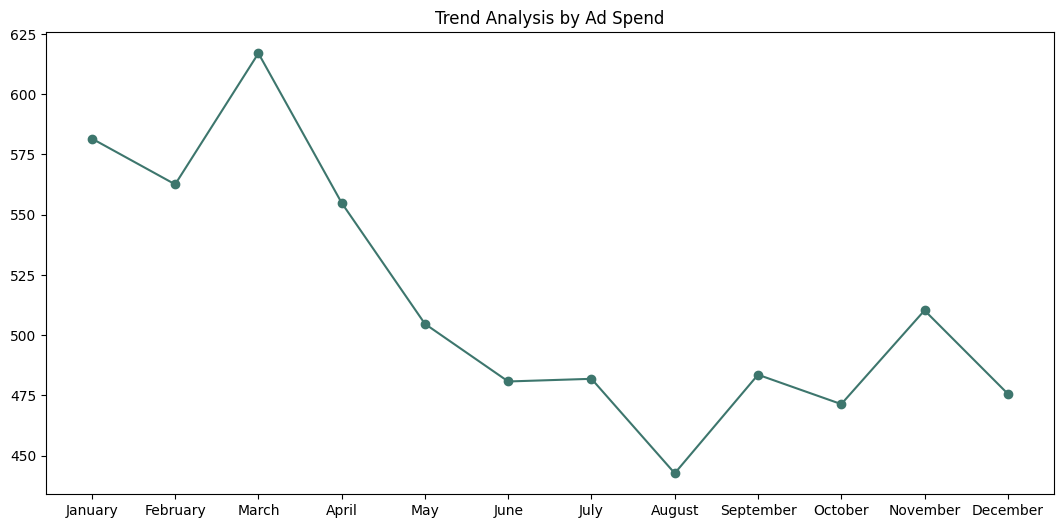

In [22]:
mtn.figure(figsize = (13,6))
mtn.plot(TimeLine["Month_Name"], TimeLine["Ad_spend"], color = mycolor, marker = 'o')
mtn.title('Trend Analysis by Ad Spend')
mtn.show()

### 4.	Which customer demographic (gender + age group) is driving the most conversion revenue?

In [23]:
customers["Detail"] = customers["Gender"] + " | " + customers["Age_Group"]

In [24]:
customers.dropna(inplace = True)
customers.rename(columns = {"Customer_ID" : "CustomerID"}, inplace = True)

In [25]:
MergedTable = customers.merge(conversions, on = 'CustomerID', how = 'inner')

In [26]:
TOP5 = MergedTable.groupby('Detail')['Revenue'].sum().reset_index().sort_values('Revenue', ascending = False).head()

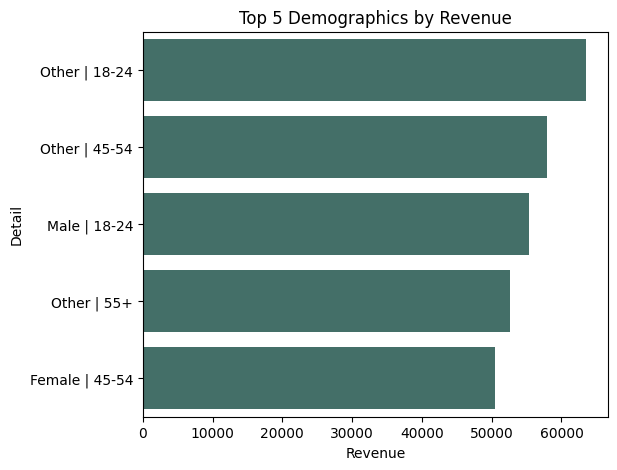

In [27]:
mtn.figure(figsize = (6,5))
sea.barplot(y = "Detail", x = "Revenue", data = TOP5, color = mycolor)
mtn.title('Top 5 Demographics by Revenue')
mtn.show()

### 5.	How do different campaign objectives (Sales, Lead Generation, Brand Awareness, App Installs) perform in terms of ROI?

In [28]:
Investment = round(performance.groupby("Campaign_ID")["Ad_spend"].sum().reset_index(),1)
Return     = conversions.groupby("CompaignID")["Revenue"].sum().reset_index()

Return.rename(columns = {"CompaignID" : "Campaign_ID"}, inplace = True)

In [29]:
AllTable = campaigns.merge(Investment, on = 'Campaign_ID', how = 'inner').merge(Return, on = 'Campaign_ID', how = 'inner')

In [30]:
ROITable = AllTable.groupby('Objective')[["Ad_spend", "Revenue"]].sum().reset_index()

In [31]:
ROITable['ROI'] = round(ROITable["Revenue"]/ROITable["Ad_spend"],1)

In [32]:
ROITable

,Objective,Ad_spend,Revenue,ROI
0,App Installs,999.2,221249,221.4
1,Brand Awareness,1915.9,160196,83.6
2,Lead Generation,394.5,107451,272.4
3,Sales,2857.6,262266,91.8


### 6.	What is the relationship between ad spend and estimated revenue across campaigns?

In [33]:
conversions.rename(columns = {"CompaignID" : "Campaign_ID"}, inplace = True)

In [34]:
Revenue = conversions.groupby("Campaign_ID")['Revenue'].sum().reset_index()
Ad_spend = round(performance.groupby("Campaign_ID")['Ad_spend'].sum().reset_index(),1)

Campaigns = campaigns.merge(Revenue, on = 'Campaign_ID', how = 'inner').merge(Ad_spend,  on = 'Campaign_ID', how = 'inner')

Matrix = Campaigns[['Revenue', 'Ad_spend']].corr()

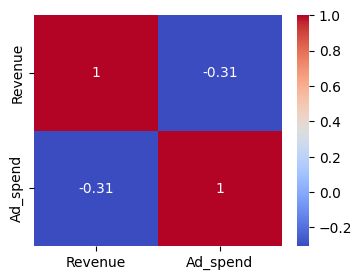

In [35]:
mtn.figure(figsize = (4,3))
sea.heatmap(Matrix, annot = True, cmap = 'coolwarm')
mtn.show()

### 7.	Which regions show the highest conversion rates?

In [36]:
Clicks = performance[performance['Status'] == 'Clicks'].groupby('Customer_ID').size().reset_index(name = 'Clicks')
conversions.rename(columns = {'CustomerID' : 'Customer_ID'}, inplace = True)

Conversions = conversions.groupby('Customer_ID').size().reset_index(name = 'Conversions')

customers.rename(columns = {"CustomerID" : "Customer_ID"}, inplace = True)

In [37]:
ConversionRate = customers.merge(Clicks, on = 'Customer_ID', how = 'inner').merge(Conversions, on = 'Customer_ID', how = 'inner')

In [38]:
RegionTable = ConversionRate.groupby('Region')[['Clicks', 'Conversions']].sum().reset_index()

In [39]:
RegionTable['ConversionRate'] = round(RegionTable['Conversions'] * 100.0 /RegionTable['Clicks'],1)

In [40]:
RegionTable

,Region,Clicks,Conversions,ConversionRate
0,East,530,50,9.4
1,North,479,22,4.6
2,South,504,36,7.1
3,West,455,26,5.7


### 8.	Analyze the distribution of revenue by Product Name and rank them from best to Worst!

In [41]:
Product_Revenue = products.merge(conversions, on = 'ProductID', how = 'inner').groupby('Product Name')['Revenue'].sum().reset_index()

In [42]:
Product_Revenue['Rank'] = Product_Revenue['Revenue'].rank(method = 'dense', ascending = False)

In [43]:
Product_Revenue.sort_values(by = 'Rank')

,Product Name,Revenue,Rank
15,Titan Hard Drive,69988,1.0
3,Echo Smart Home Hub,67618,2.0
5,Galaxy Soundbar,66326,3.0
8,Omni VR Headset,58514,4.0
12,Solar Powerbank,55085,5.0
16,UltraSonic Headphones,48581,6.0
11,Quantum Phone X,47667,7.0
7,Nova Tablet,47355,8.0
4,Flex Fitness Band,46475,9.0
6,Nova Coffee Maker,39059,10.0


### 9.	Does campaign duration impact conversion revenue generated?

In [44]:
campaigns['Start_Date'] = pd.to_datetime(campaigns['Start_Date'], format = 'mixed')
campaigns['End_Date'] = pd.to_datetime(campaigns['End_Date'], format = 'mixed')

In [45]:
campaigns['Days']  = abs((campaigns['Start_Date'] - campaigns['End_Date']).dt.days)

In [46]:
Daystable = campaigns[['Campaign_ID', 'Days', 'Campaign_Name']].merge(conversions, on = 'Campaign_ID', how = 'inner')

In [47]:
FinalTable = Daystable.groupby('Campaign_Name')[['Days', 'Revenue']].sum().reset_index()

In [48]:
matrix = FinalTable[['Days', 'Revenue']].corr()

--------------------------------------------------


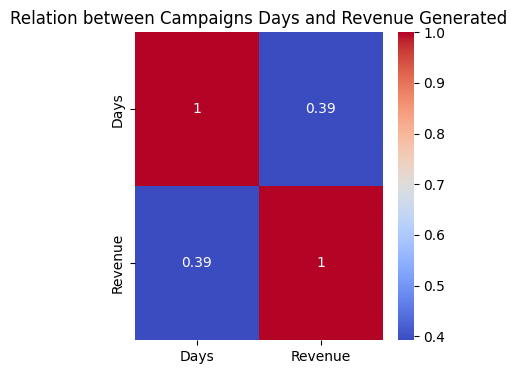

In [49]:
mtn.figure(figsize = (4,4))
mtn.title('Relation between Campaigns Days and Revenue Generated')
print('-'*50)
sea.heatmap(matrix, annot = True, cmap = 'coolwarm')
mtn.show()

### 10.	Which campaigns had high impressions but low conversions (inefficient spend)?

In [50]:
# ----- Impressions Table

impressions = performance[performance['Status'] == 'Impressions'].groupby('Campaign_ID').size().reset_index(name = 'Impressions')

# ----- Conversions Table

Conversions = conversions.groupby('Campaign_ID').size().reset_index(name = 'Conversions')

# ----- Combined Table

Combined = campaigns[['Campaign_ID', 'Campaign_Name']].merge(impressions, on = 'Campaign_ID', how = 'inner').merge(Conversions, on = 'Campaign_ID', how = 'inner')

Combined['ImpRank'] = round(Combined['Impressions'].rank(method = 'dense', ascending  = False),0)
Combined['ConRank'] = Combined['Conversions'].rank(method = 'dense', ascending = True)

In [51]:
name = Combined[Combined['ImpRank'] == 1.0]['Campaign_Name'].iloc[0]
print(f'Campaign "{name}" had high impressions but low conversions')

Campaign "New Arrival: Smart Gadgets" had high impressions but low conversions


### 11.	Do product colors show any significant differences in conversion rates?

In [52]:
# ProductConversions
# ProductClicks
ColorTable = products[['ProductID', 'Color']].merge(ProductClicks, on = 'ProductID', how = 'inner').merge(ProductConversions, on = 'ProductID', how = 'inner')

In [53]:
Conversion = ColorTable.groupby('Color')[['Clicks', 'Conversions']].sum().reset_index()
Conversion['ConversionRate'] = round(ColorTable['Conversions'] * 100.0/ColorTable['Clicks'],1)

In [54]:
Conversion

,Color,Clicks,Conversions,ConversionRate
0,Black,989,32,2.3
1,Blue,875,29,3.6
2,Navy,1073,24,3.9
3,Red,2063,65,2.9


### 12.	Identify the most valuable customer segments (Region + Age Group + Gender) in terms of lifetime revenue.

In [55]:
customers['Segment'] = customers['Region'] + ' | ' + customers['Detail']

In [56]:
RevenueTable = customers[['Customer_ID', 'Segment']].merge(conversions, on = 'Customer_ID', how = 'inner')

In [57]:
RevenueTable.groupby('Segment')['Revenue'].sum().reset_index().sort_values(by = 'Revenue', ascending = False).head(6)

,Segment,Revenue
20,North | Other | 18-24,50711
30,South | Male | 45-54,34900
22,North | Other | 45-54,32654
4,East | Male | 18-24,32323
11,East | Other | 55+,31588
6,East | Male | 55+,29057


### 13.	How does estimated revenue compare to actual conversion revenue across campaigns?

In [58]:
# ---- Estimated Revenue

EstimatedRevenue = performance.groupby('Campaign_ID')['Estimated Revenue'].sum().reset_index()

# ----- Actual Revenue

ActualRevenue = conversions.groupby('Campaign_ID')['Revenue'].sum().reset_index()

campaigns[['Campaign_ID', 'Campaign_Name']].merge(EstimatedRevenue, on = 'Campaign_ID', how = 'inner').merge(ActualRevenue, on = 'Campaign_ID', how = 'inner')

,Campaign_ID,Campaign_Name,Estimated Revenue,Revenue
0,1,Summer Splash Sale,17354636,106010
1,2,New Arrival: Smart Gadgets,17095738,30052
2,3,Year-End Clearance,17263263,43461
3,4,Flash Deal Friday,4864580,50001
4,5,Refer & Earn Campaign,5020225,107451
5,6,Limited Time Tech Promo,5112295,51658
6,7,Winter Fitness Kickstart,5022475,112795
7,8,Back to School Essentials,4774332,70558
8,9,Black Friday Early Access,4824772,78486
9,10,Buy 1 Get 1 ?? Festive Bonanza,5027604,100690
